# Project 6_Kaiyue Wu

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import norm

new_line = '\n'
pd.options.mode.chained_assignment = None 
import warnings
warnings.filterwarnings('ignore')

sns.set(font_scale=1.5, rc={'text.usetex' : True,})
%config InlineBackend.figure_format='retina'

In [2]:
# simulate stock prices
def simulate_gbm(s_0, mu, sigma, n_sims, T, step, antithetic_var=False):
    
    """
    simulation of stock prices with antithetic variables to reduce variance
    """
    
    dt = T/step
    
    # Antithetic variables
    if antithetic_var:
        dW_ant = np.random.normal(scale = np.sqrt(dt), 
                                  size=(int(n_sims/2), step + 1))
        dW = np.concatenate((dW_ant, -dW_ant), axis=0)
    else: 
        dW = np.random.normal(scale = np.sqrt(dt), 
                              size=(n_sims, step + 1))
  
    St = np.zeros((n_sims, step + 1))
    St[:, 0] = s_0
    
    for i in range (1, step + 1):
        St[:, i] = St[:, i - 1]*np.exp((mu - 1/2*np.power(sigma, 2))*dt + sigma*dW[:, i - 1])
    
    return St


## 1. Fixed Strike Lookback Call and Put options

In [3]:
def fixedStrike(s0,k,r,sigma,T,path,option_type='call'):
    """
    Assume European Style
    """
    steps = 252
    dt = T/steps
    St = simulate_gbm(s_0=s0,mu=r,sigma=sigma,n_sims=path,T=T,step=steps)
    disc = np.exp(-r*T)
    
    if option_type.lower() == 'call':
        maxPrice = np.zeros(path)
        for i in range(path):
            maxPrice[i] = St[i].max()
        payoff = np.maximum( maxPrice-k ,0)
        price = np.mean(payoff) * disc
        
    elif option_type.lower() == 'put':
        minPrice = np.zeros(path)
        for i in range(path):
            minPrice[i] = St[i].min()
        payoff = np.maximum( k-minPrice ,0)
        price = np.mean(payoff) * disc
        
    return price

In [4]:
# parameter set up
T = 1
r = 0.03
s0 = 98
k = 100
vol = np.arange(0.12,0.51,0.04)

# calculate call and put prices
call_option = [fixedStrike(s0=s0,k=k,r=r,T=T,sigma=i,path=1000,option_type='call') for i in vol]
put_option = [fixedStrike(s0=s0,k=k,r=r,T=T,sigma=i,path=1000,option_type='put') for i in vol]

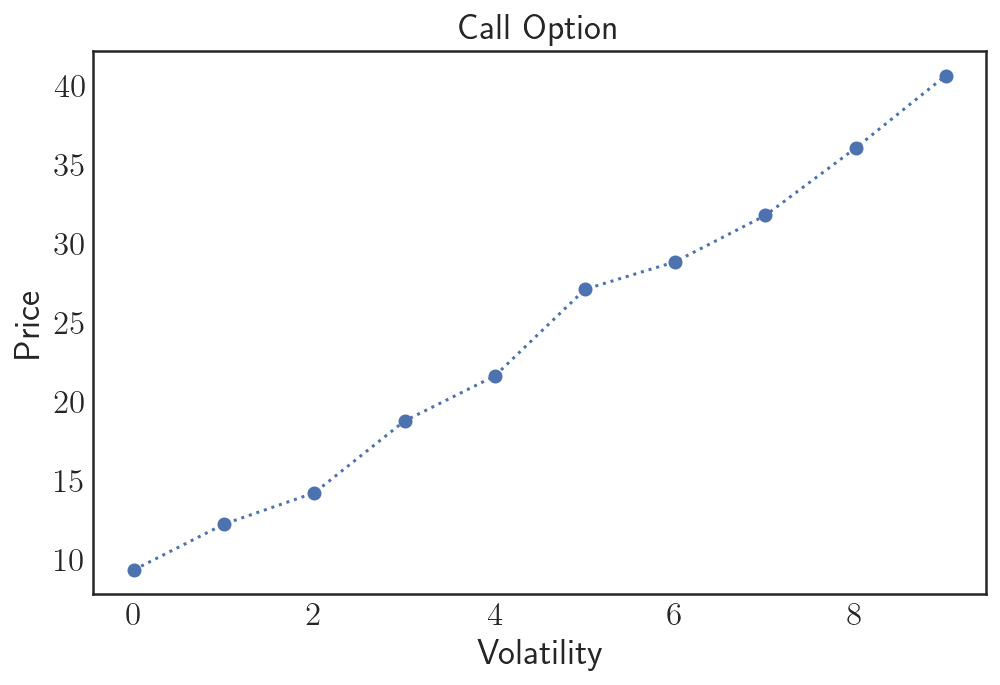

In [5]:
# Call Graph
plt.figure(figsize=(8,5))
plt.style.use('seaborn-white')

plt.plot(call_option,marker='o',linestyle = ':')
plt.ylabel('Price')
plt.xlabel('Volatility')
plt.title('Call Option')
plt.show()

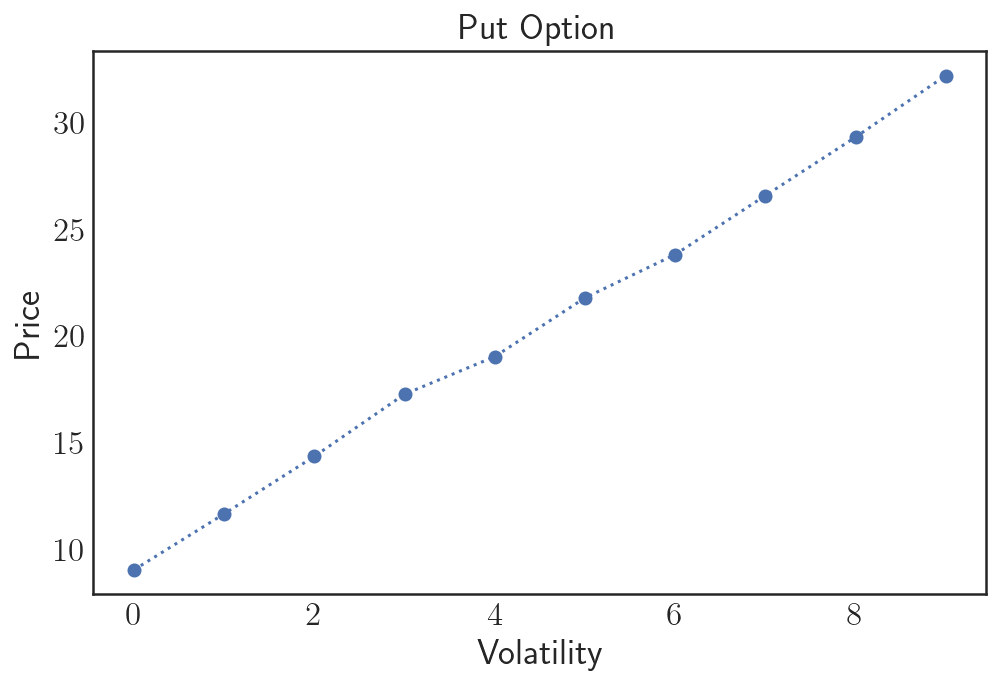

In [112]:
# Put Graph

plt.figure(figsize=(8,5))
plt.style.use('seaborn-white')

plt.plot(put_option,marker='o',linestyle = ':')
plt.ylabel('Price')
plt.xlabel('Volatility')
plt.title('Put Option')


plt.show()

## 2. Jump-diffusion process

__Jump-diffusion process:__

$\frac{dV_t}{V_t} = \mu dt + \sigma dW_t + \gamma dJ_t$

__Consider a collateralized loan, with a contract rate per period r and maturity T on the above-collateral, and assume the outstanding balance of that loan follows this process:__

$L_t = a-bc^{12t}$

where a>0, b>0 , c>1, 𝑎𝑛𝑑 $L_0$ are given. We have that $L_t$ = 0.


In [98]:
def loanVt(V0,mu,sigma,gamma,lambda1,T,paths):
    
    steps = T*12
    dt = T/steps
    
    Vt = np.zeros((paths,steps+1))
    Vt[:,0] = V0
    
    
    # the time of occurrence of the first Poisson realization 
    # (and the time between any two consectuive Poisson
    # realization) is exponential distributed random variables 
    #with the same intensity as one of the Possion process
    
    for i in range(steps):
     
        Z = np.random.normal(0,1,paths)
        dWt = np.sqrt(dt)*Z
        # J ~ Poisson(lambda1)
        dJt = np.random.poisson(dt*lambda1,paths)
        Vt[:,i+1] = Vt[:,i]*np.exp((mu-0.5*sigma**2)*dt+sigma*dWt)*(1+gamma*dJt)
    Vt = Vt[:,1:]
    
    return Vt

In [99]:
def jumpDiff(lambda1=0.2,lambda2=0.4,T=5):

    np.random.seed(0)
    # set up default parameters
    V0 = 20000
    L0 = 22000
    mu = -0.1
    sigma = 0.2
    gamma = -0.4
    r0 = 0.02              # risk-free rate
    delta = 0.25
    alpha = 0.7
    epsilon = 0.95         # recovery rate
    
    steps = T*12
    dt = T/steps
    paths = 100000
    t = np.arange(1/12,T+dt,dt)
    qT = epsilon
    
    R = r0 + gamma*lambda2  # APR
    r = R/12
    n = T*12
    PMT = (L0*r) / (1-1/(1+r)**n)
    
    a = PMT/r
    b = PMT/(r*(1+r)**n)
    c = 1+r
    # Loan Balance
    Lt = a-b*c**(12*t)
    
    beta = (epsilon-alpha)/T
    qt = alpha + beta*t
    
    Vt = loanVt(V0=V0,mu=mu,sigma=sigma,lambda1=lambda1,gamma=gamma,T=T,paths=paths)
    
    residual_value = np.tile(Lt*qt,paths).reshape((paths,steps))
    D = np.where(Vt-residual_value<= 0, 1, 0)
    # Find the first time valur cross the threshold
    Q = np.argmax(D, axis = 1)*dt
    # Non-default paths
    ND = np.where(np.sum(D, axis = 1) == 0)
    Q[ND] = 10000
    
    # N ~ Poisson(lambda2)
    Nt=np.clip(np.random.poisson(lambda2*dt,(paths,steps)),0,1)
    S=np.argmax(Nt,axis=1)*dt
    ND2 = np.where(np.sum(Nt, axis = 1) == 0)
    S[ND2] = 10000

    count = 0
    payoff = np.zeros(paths)
    for i in range(paths):
        if Q[i] == 10000 and S[i] == 10000:
            payoff[i]=0
        elif Q[i] <= S[i]:
            LQ = a-b*c**(12*Q[i])
            VQ = Vt[i,int(Q[i]/dt)]
            payoff[i]=np.maximum(LQ-epsilon*VQ,0)*np.exp(-r0*Q[i])
            count += 1
        elif Q[i] > S[i]:
            LS = a-b*c**(12*S[i])
            VS = Vt[i,int(S[i]/dt)]
            payoff[i]=np.abs(LS-epsilon*VS)*np.exp(-r0*S[i])
            count += 1        
 
    tau = np.minimum(S,Q)
    for i in range(len(tau)):
        if tau[i]>T:
            payoff[i] = 0
            tau[i]=0

    Value = round(np.mean(payoff),2)
    Prob = round(count/paths,2)
    Et = round(np.mean(tau),2)
    
    return Value,Prob,Et

### Default Value

In [101]:
defaultD = jumpDiff(lambda1=0.2,lambda2=0.4,T=5)[0]
defaultP = jumpDiff(lambda1=0.2,lambda2=0.4,T=5)[1]
defaultEt = jumpDiff(lambda1=0.2,lambda2=0.4,T=5)[2]

print(f"the default option D is           {defaultD}. {new_line}the default probability Prob is   {defaultP}. \
      {new_line}the expected exercise time Et is  {defaultEt} ")

the default option D is           4374.32. 
the default probability Prob is   0.92.       
the expected exercise time Et is  1.18 


In [102]:
# 𝜆1 from 0.05 to 0.4 in increments of 0.05; #8
lambda1 = np.arange(0.05,0.45,0.05)

# 𝜆2 from 0.0 to 0.8 in increments of 0.1;  #9
lambda2 = np.arange(0.0,0.9,0.1)

# T from 3 to 8 in increments of 1;         #6
T = np.arange(3,9,1)

### (a) Value of Default Option

In [103]:
# first with 𝜆1=0.2
Qa_A = np.zeros((len(T),len(lambda2)))
for i in range(len(T)):
    for j in range(len(lambda2)):
        Qa_A[i,j] = jumpDiff(lambda1=0.2,lambda2=lambda2[j],T=T[i])[0]
        
# then with 𝜆2 = 0.4
Qa_B = np.zeros((len(T),len(lambda1)))
for i in range(len(T)):
    for j in range(len(lambda1)):
        Qa_B[i,j] = jumpDiff(lambda1=lambda1[j],lambda2=0.4,T=T[i])[0]

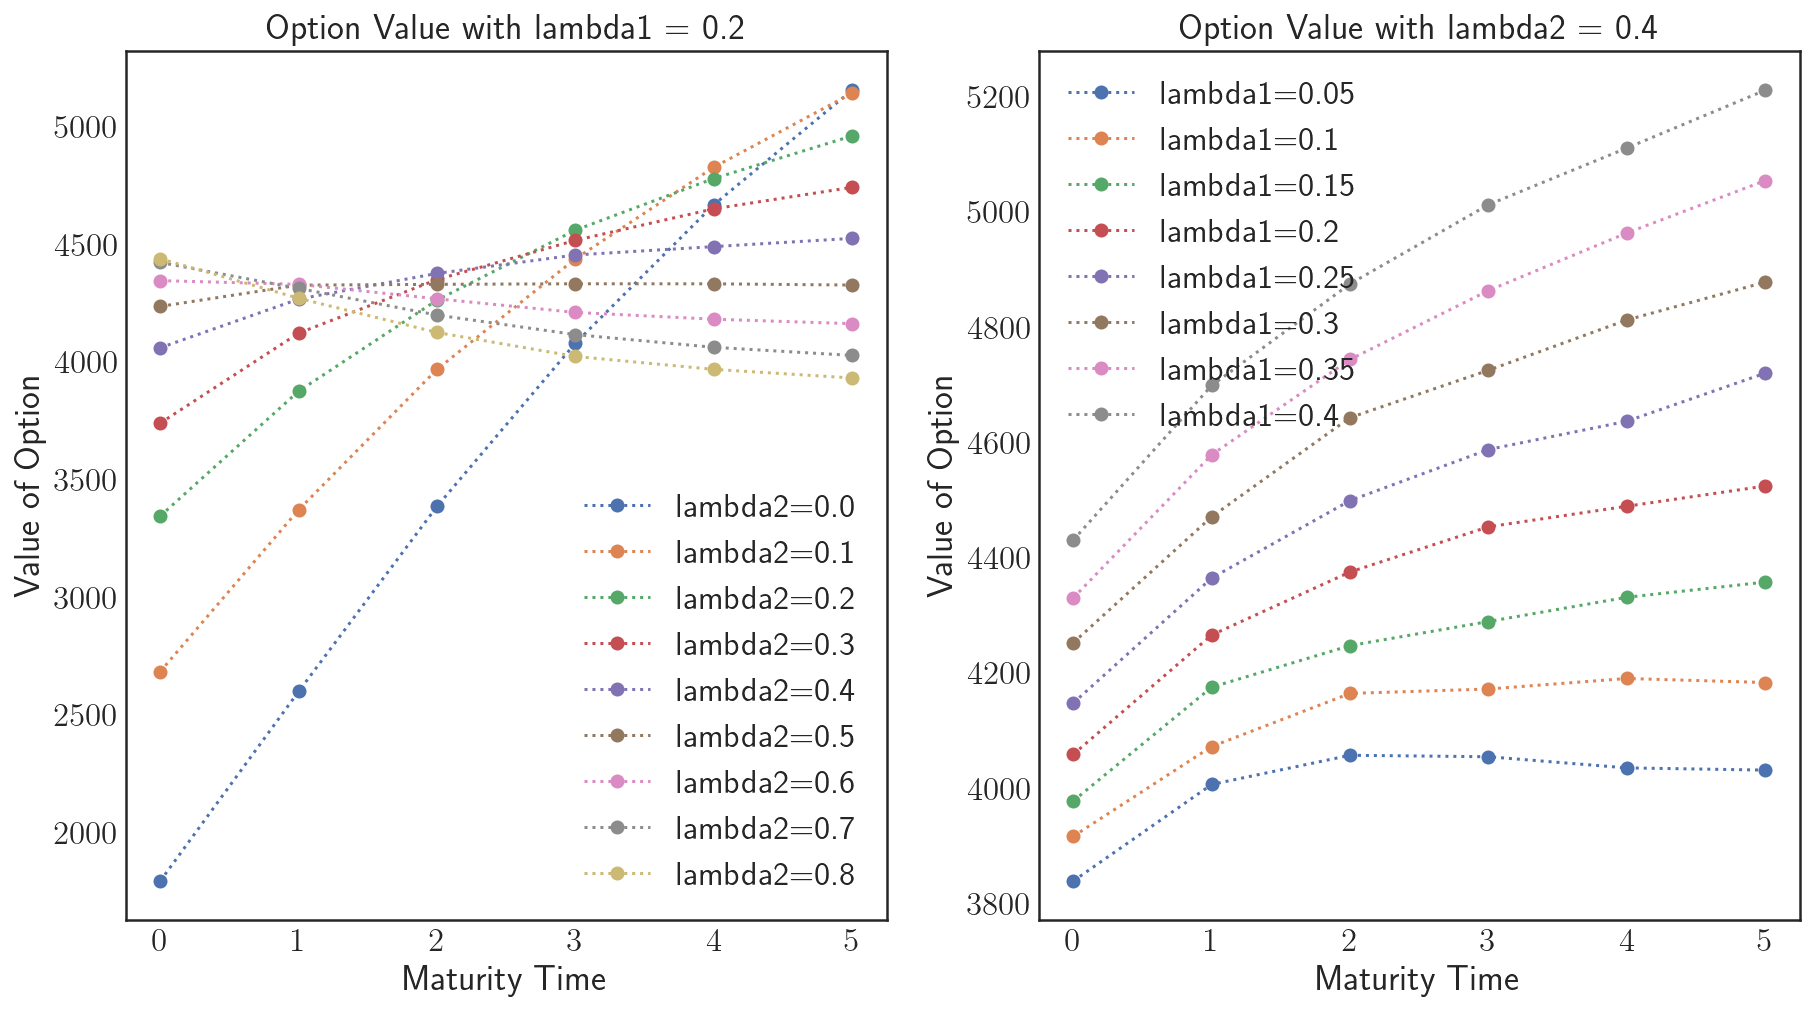

In [104]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.plot(Qa_A,marker='o',linestyle = ':')
plt.title('Option Value with lambda1 = 0.2')
plt.xlabel('Maturity Time')
plt.ylabel('Value of Option')
plt.legend(["lambda2=" + str(round(i,2)) for i in lambda2])

plt.subplot(1,2,2)
plt.plot(Qa_B,marker='o',linestyle = ':')
plt.title('Option Value with lambda2 = 0.4')
plt.xlabel('Maturity Time')
plt.ylabel('Value of Option')
plt.legend(["lambda1=" + str(round(i,2)) for i in lambda1])

plt.show()

### (b) Default Probability

In [105]:
# first with 𝜆1=0.2
Qb_A = np.zeros((len(T),len(lambda2)))
for i in range(len(T)):
    for j in range(len(lambda2)):
        Qb_A[i,j] = jumpDiff(lambda1=0.2,lambda2=lambda2[j],T=T[i])[1]
        
# then with 𝜆2 = 0.4
Qb_B = np.zeros((len(T),len(lambda1)))
for i in range(len(T)):
    for j in range(len(lambda1)):
        Qb_B[i,j] = jumpDiff(lambda1=lambda1[j],lambda2=0.4,T=T[i])[1]

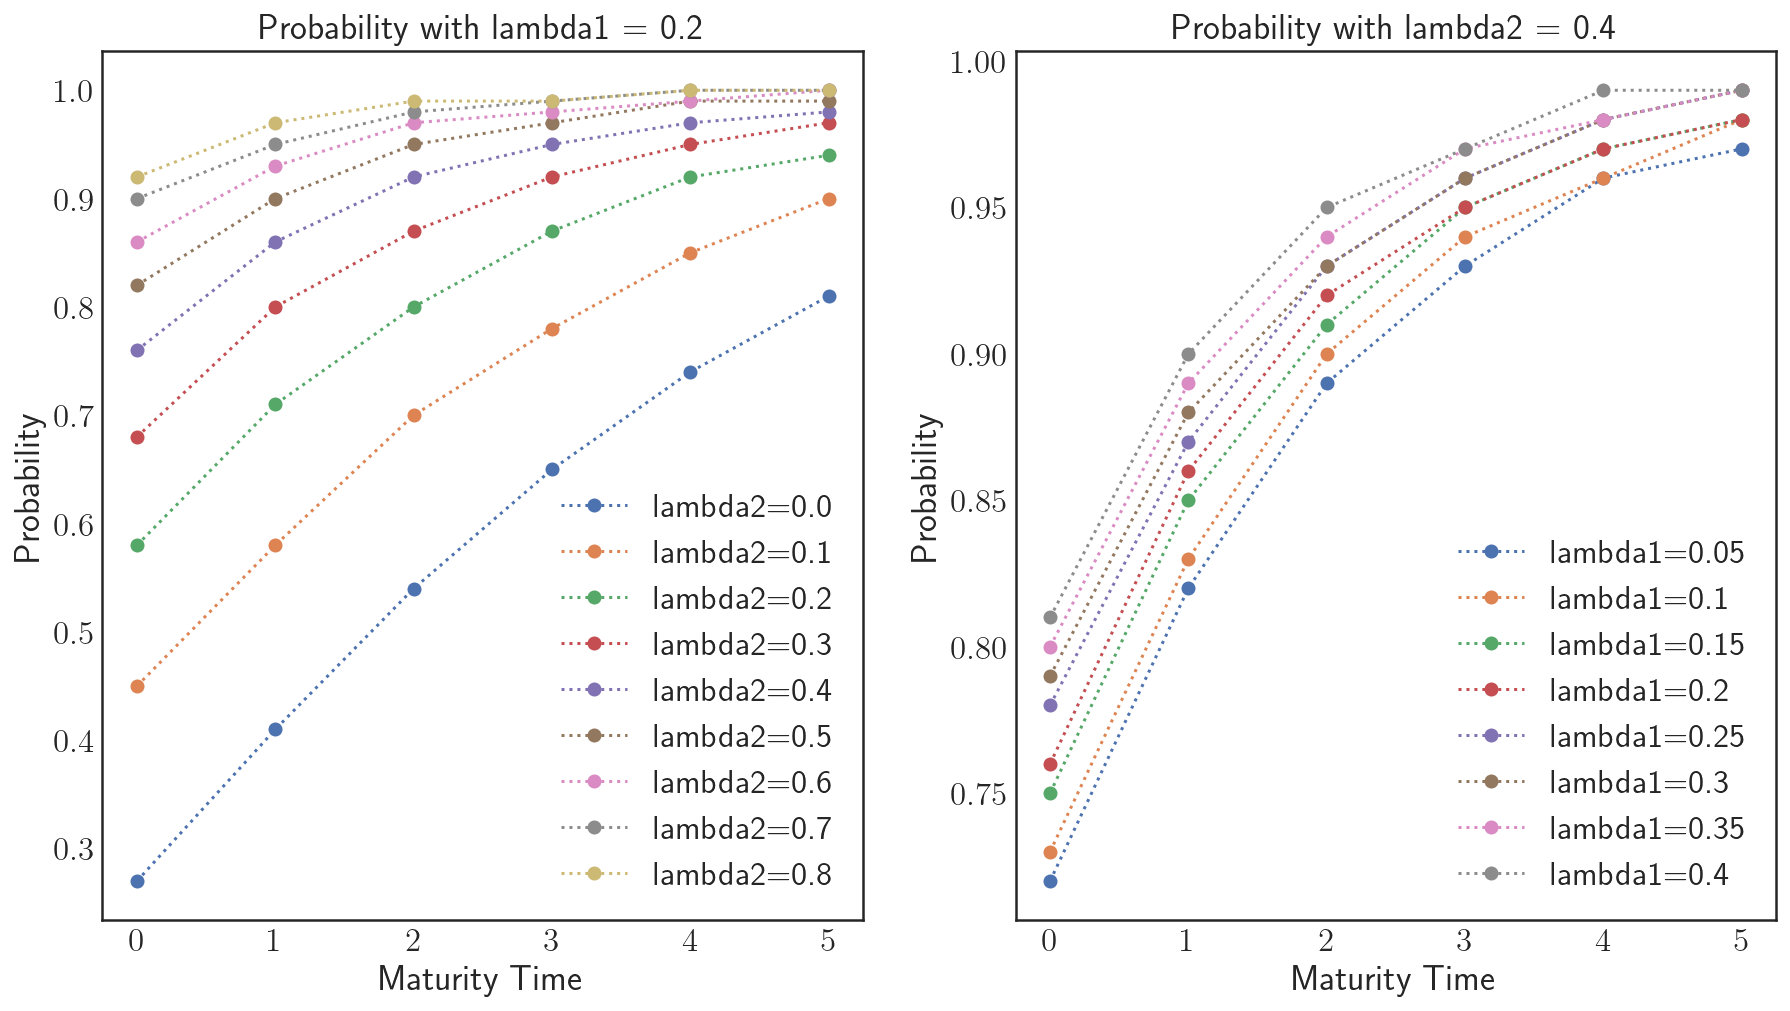

In [106]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.plot(Qb_A,marker='o',linestyle = ':')
plt.title('Probability with lambda1 = 0.2')
plt.xlabel('Maturity Time')
plt.ylabel('Probability')
plt.legend(["lambda2=" + str(round(i,2)) for i in lambda2])

plt.subplot(1,2,2)
plt.plot(Qb_B,marker='o',linestyle = ':')
plt.title('Probability with lambda2 = 0.4')
plt.xlabel('Maturity Time')
plt.ylabel('Probability')
plt.legend(["lambda1=" + str(round(i,2)) for i in lambda1])

plt.show()

In [ ]:
plt.savefig('books_read.png')

### (c) Expected Exercise Time

In [107]:
# first with 𝜆1=0.2
Qc_A = np.zeros((len(T),len(lambda2)))
for i in range(len(T)):
    for j in range(len(lambda2)):
        Qc_A[i,j] = jumpDiff(lambda1=0.2,lambda2=lambda2[j],T=T[i])[2]
        
# then with 𝜆2 = 0.4
Qc_B = np.zeros((len(T),len(lambda1)))
for i in range(len(T)):
    for j in range(len(lambda1)):
        Qc_B[i,j] = jumpDiff(lambda1=lambda1[j],lambda2=0.4,T=T[i])[2]

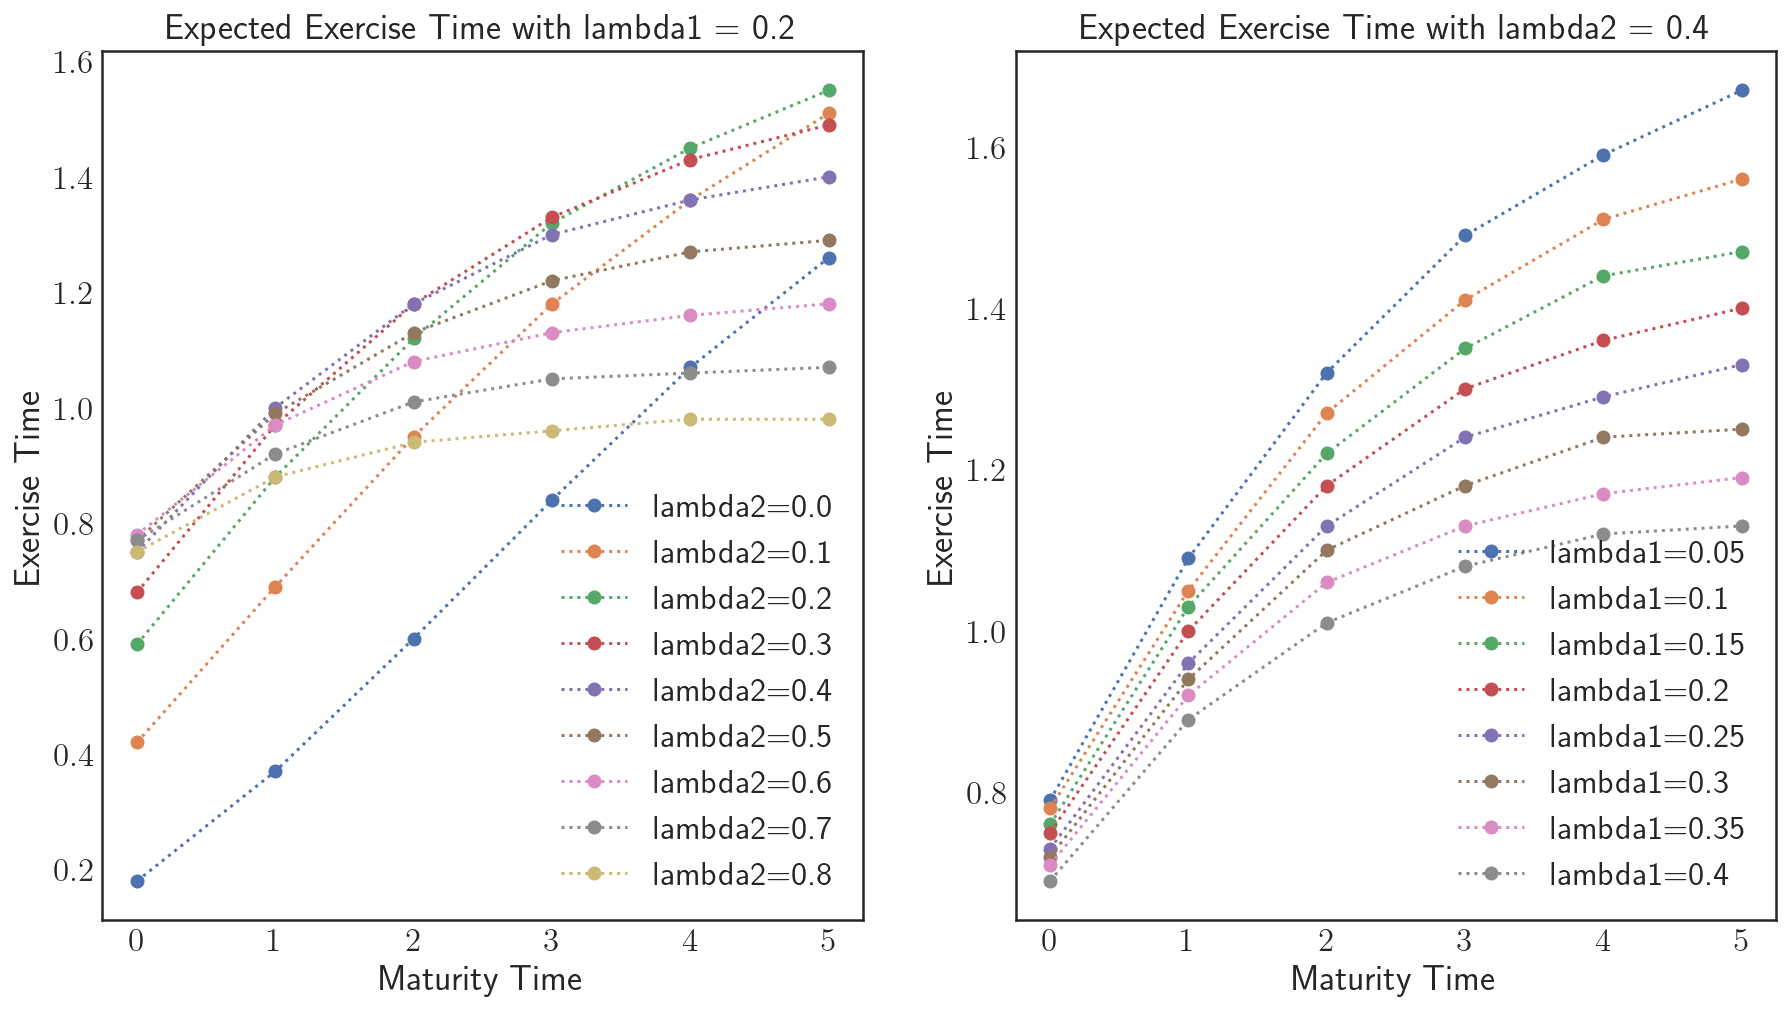

In [108]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.plot(Qc_A,marker='o',linestyle = ':')
plt.title('Expected Exercise Time with lambda1 = 0.2')
plt.xlabel('Maturity Time')
plt.ylabel('Exercise Time')
plt.legend(["lambda2=" + str(round(i,2)) for i in lambda2])

plt.subplot(1,2,2)
plt.plot(Qc_B,marker='o',linestyle = ':')
plt.title('Expected Exercise Time with lambda2 = 0.4')
plt.xlabel('Maturity Time')
plt.ylabel('Exercise Time')
plt.legend(["lambda1=" + str(round(i,2)) for i in lambda1])

plt.show()